# Sascha Jecklin's Homework assignment
The notebook shows the complete process from segmentation to prediction. The process is then repeated afterwards with all remaining images in the folder /images.



In [1]:
import numpy as np
import pathlib
import skimage.feature
import skimage.transform.hough_transform as ht
import skimage.transform as trans
import glob
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, opening
import matplotlib.patches as patches
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
%matplotlib inline

import ipywidgets as widgets

ddir = pathlib.Path("images")
print(f"We expect the data files in directory {ddir.absolute()}")

from os import walk

f = []
for (dirpath, dirnames, filenames) in walk(ddir):
    f.extend(filenames)
    break
    
img = [skimage.io.imread(file) for file in glob.glob(f"{ddir.absolute()}/*.jpg")]

Using TensorFlow backend.


We expect the data files in directory /Users/saschajecklin/Dropbox/02 Master/Semester_2/TSM_CompVis/05 Practical image classification with convnets and 1st homework assignment/images


In [2]:
index = 0
filename = f[index] #filename for alter

(-0.5, 4031.5, 3023.5, -0.5)

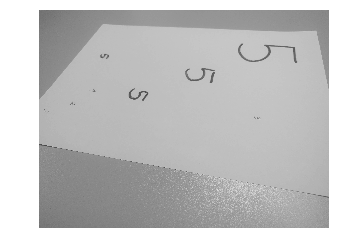

In [3]:
gray_img = skimage.color.rgb2gray(img[index])
plt.imshow(gray_img,
           vmin=0,   # value which maps to black
           vmax=1, # value which maps to white
           cmap="gray")
plt.axis("off")

(-0.5, 4031.5, 3023.5, -0.5)

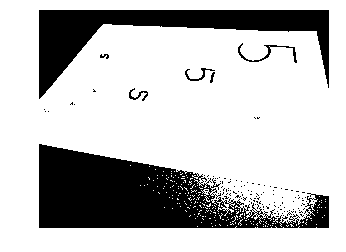

In [4]:
thresh = skimage.filters.threshold_otsu(gray_img)
binary = gray_img > thresh #threshold with otsu for better segmentation

plt.imshow(binary,
           vmin=0,   # value which maps to black
           vmax=1, # value which maps to white
           cmap="gray")
plt.axis("off")

A canny edege detection followed by a hough transformation. The parameters have first been identified with the help of ipywidgets

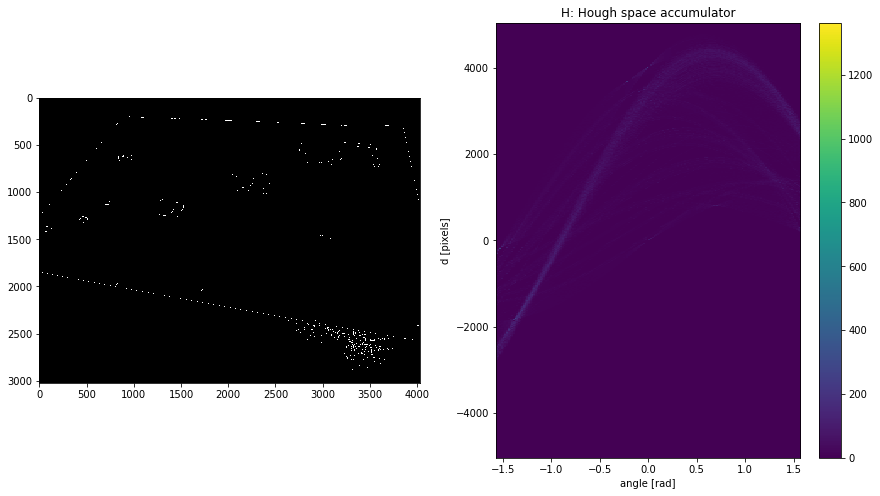

In [5]:
canny_sigma=1.7
canny_low_threshold=0.04#0.20
canny_high_threshold=0.08#0.20
hough_threshold=150
imedges = skimage.feature.canny(binary,
                                low_threshold=canny_low_threshold,
                                high_threshold=canny_high_threshold,
                                sigma=canny_sigma)

H,angles,distances = ht.hough_line(imedges)

fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(imedges, cmap="gray")
Himage = ax1.imshow(H,
                    extent=(angles[0],angles[-1],distances[0],distances[-1]),
                    origin="lower", aspect="auto")
ax1.set(xlabel="angle [rad]",
        ylabel="d [pixels]",
        title="H: Hough space accumulator");
plt.colorbar(Himage)

The four most dominat points in the hough space have been choosen in a way, that they most probabily belong to the paper sheet.

[-1838.68240897  -176.51751166  3715.86863776   815.5809108 ] [-1.39528836 -1.53569473 -0.20183416  0.69325648]


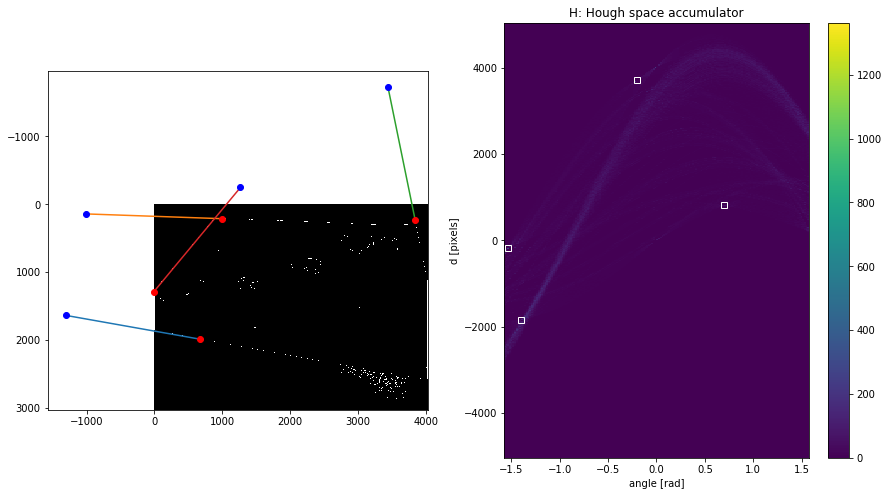

In [6]:
hough_point = trans.hough_line_peaks(H, angles, distances, threshold=300, min_distance=1000, min_angle=30)
d = hough_point[2]
theta = hough_point[1]
print(d,theta)

# Same figure as before...
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(imedges, cmap="gray")
Himage = ax1.imshow(H,extent=(angles[0],angles[-1],distances[0],distances[-1]),origin="lower",aspect="auto")
ax1.set(xlabel="angle [rad]",
        ylabel="d [pixels]",
        title="H: Hough space accumulator");
plt.colorbar(Himage)

# Plot a white rectangle over the maximum
ax1.plot(theta, d, "ws", fillstyle="none")

## Now we want to draw the line in image space
# This is one point on the line
p1 = np.array([d*np.cos(theta), d*np.sin(theta)])
# This is the unit vector pointing in the direction of the line (remember what theta means in Hough space!)
linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
# These are two points very far away in two opposite directions along the line
p0 = p1 - linedir * 1000
p2 = p1 + linedir * 1000
# We now draw a line through p0 and p2, without rescaling the axes.
ax0.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)
ax0.plot(p0[0],p0[1],'bo')
ax0.plot(p2[0],p2[1],'ro')
#ax0.plot([x0,x1],[y0,y1],'b-')

The intersections are calcuated with the help of homogenoius coordinates presented in the lecture.

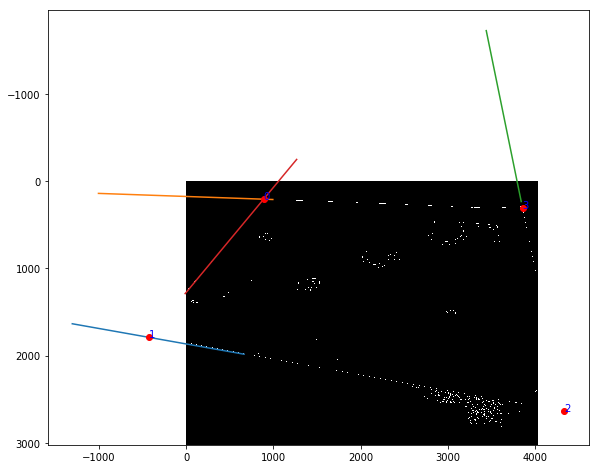

In [7]:
a1 = (np.vstack((p0,[1,1,1,1]))[:,0])
a2 = (np.vstack((p2,[1,1,1,1]))[:,0])
b1 = (np.vstack((p0,[1,1,1,1]))[:,1])
b2 = (np.vstack((p2,[1,1,1,1]))[:,1])
c1 = (np.vstack((p0,[1,1,1,1]))[:,2])
c2 = (np.vstack((p2,[1,1,1,1]))[:,2])
d1 = (np.vstack((p0,[1,1,1,1]))[:,3])
d2 = (np.vstack((p2,[1,1,1,1]))[:,3])

def get_intersection(point11, point12, point21, point22):
    la=np.cross(point11,point12)
    lb=np.cross(point21,point22)
    
    inter = np.cross(la,lb)
    inter= inter / inter[2]
    return(inter[:2])

intersec = []
intersec.append(get_intersection(a1,a2,b1,b2))
intersec.append(get_intersection(a1,a2,c1,c2))
intersec.append(get_intersection(a1,a2,d1,d2))
intersec.append(get_intersection(b1,b2,c1,c2))
intersec.append(get_intersection(b1,b2,d1,d2))
intersec.append(get_intersection(c1,c2,d1,d2))

possible_intersec = []
for inter in intersec:
    if inter[0] > -1000 and inter[1] > -1000:
        possible_intersec.append(inter)
    
possible_intersec = np.array(possible_intersec)

def sort_intersec(intersections):
    mean = np.mean(intersections, axis=0)
    intersections = intersections - mean
    sorted_intersec = []
    for idx, inter in enumerate(intersections):
        sorted_intersec.append( np.hstack((np.arctan2(inter[0],inter[1]), possible_intersec[idx])) )

    sorted_intersec = np.array(sorted_intersec)
    sorted_intersec = sorted_intersec[sorted_intersec[:,0].argsort()]
    return sorted_intersec[:,1:3]

sorted_intersec = sort_intersec(possible_intersec)

# Same figure as before...
fig,(ax0) = plt.subplots(ncols=1, nrows=1, figsize=(15,8))
ax0.imshow(imedges, cmap="gray")
ax0.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)

for idx, i in enumerate(sorted_intersec):
    ax0.plot(i[0], i[1], 'ro')
    ax0.annotate(idx, (i[0], i[1]), color='blue')

The found intersections have then been sorted by moving them to the origin(-mean) and taking the angle with respect to the origin. This assures that always a anti-clockwhise order exist. The two longer lines are assumed to be the longer sides of the sheet.

In [8]:
line_1 = sorted_intersec[1]-sorted_intersec[0]
line_2 = sorted_intersec[2]-sorted_intersec[1]
line_3 = sorted_intersec[3]-sorted_intersec[2]
line_4 = sorted_intersec[0]-sorted_intersec[3]

def get_line_length(line_a):
    return (line_a[0]**2+line_a[1]**2)**0.5

def get_orientation():
    if (get_line_length(line_1)+get_line_length(line_3)) > (get_line_length(line_2)+get_line_length(line_4)):
        h = 2000
        w = np.floor(h*(2**0.5))
    else:
        w = 2000
        h = np.floor(w*(2**0.5))
    return w,h

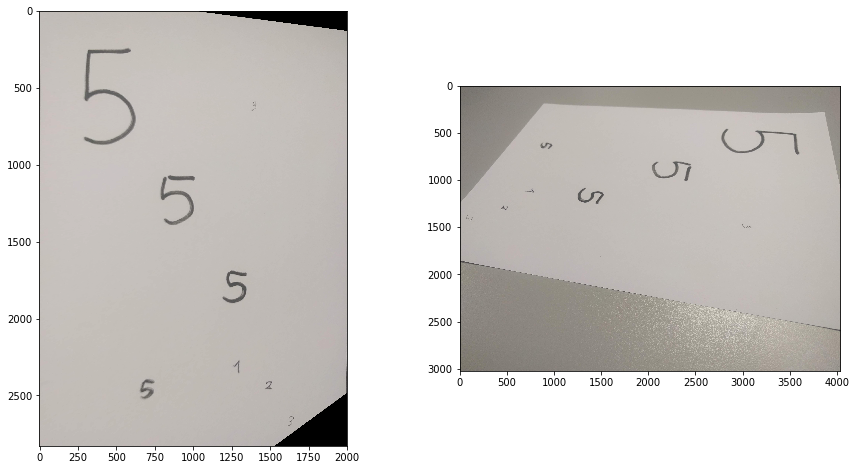

In [9]:
def transform(intersections, image):
    w,h = get_orientation()
    a = np.array([0,h])
    b = np.array([w,h])
    c = np.array([w,0])
    d = np.array([0,0])
    tf = skimage.transform.estimate_transform("projective",
        dst=np.vstack((a,b,c,d)),
        src=intersections)
    invtf = tf.inverse
    transformedImage = skimage.transform.warp(image=image,inverse_map=invtf, output_shape=(h,w))
    return transformedImage

fig,(ax0,ax1) = plt.subplots(ncols=2, figsize=(15,8))

transformed_image = transform(sorted_intersec, img[index] )
ax0.imshow(transformed_image,cmap="gray")

ax1.imshow(img[index])

In the transformed image the individual numbers are cut out.

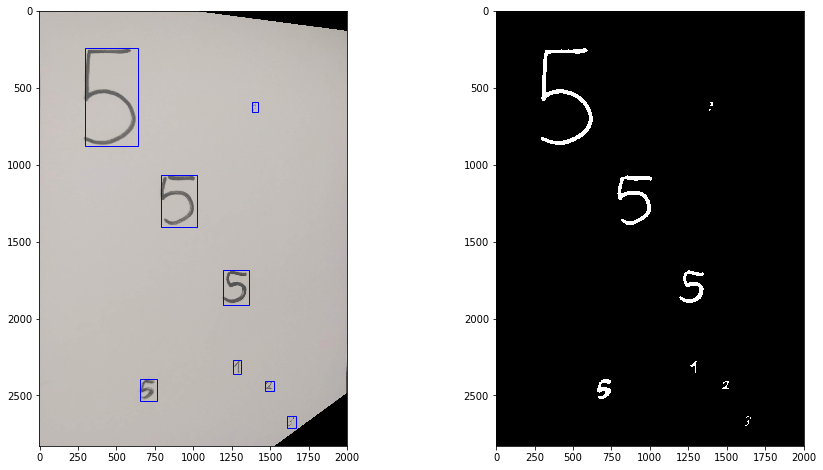

In [10]:
transformed_image_binary = transform(sorted_intersec, binary) 
fig,(ax0,ax1) = plt.subplots(ncols=2, figsize=(15,8))

bw = opening(transformed_image_binary, square(11))
bw = 1-bw
ax0.imshow(transformed_image, cmap="gray")

cleared = clear_border(bw)
label_image = label(cleared)

ax1.imshow(cleared, cmap="gray")

regions = skimage.measure.regionprops(label_image)
large_regions = [r for r in regions if r.area > 8]

for r in large_regions:
    (min_row, min_col, max_row, max_col) = r.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row),width+10,height+10,
                             linewidth=1,edgecolor='b',facecolor='none')
    ax0.add_patch(rect)

The model for MNIST prediction was taken from the github. It is well used and achives up to 99.7% accuracy on the validation data. The network is only trained once since the weights are stored.

In [11]:
def create_model():
    batch_size = 128
    num_classes = 10
    epochs = 12

    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

def train_model():
    model = create_model()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
        
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model.save_weights("model.h5")


In [12]:
def load_trained_model(weights_path):
    model = create_model()
    model.load_weights(weights_path)
    return model

In [13]:
def plot_pred_prob(image, predicted):
    #print(predictions)
    ix = np.argsort(predicted)[0][:-4:-1] # indices of the 3 largest elements
    #print(ix)
    #print(p[0][ix])

    fig,(ax1,ax2) = plt.subplots(ncols=2)
    ax1.imshow(image, cmap="gray")
    ax2.bar(x=[1,2,3], height=predicted[0][ix])
    ax2.set(ylim=[0,1],
            xticks=[1,2,3],
            xticklabels=ix,
            title="3 most probable classes")

The numbers get extraced and rotated four times by 90°. Each time the numbers will be predicted. The series of prediction with the highest sum is assumed to have the correct orientation.

For simplicity the numbers get then predicted once again in the correct orientation. The predictions and the file number is printed out.

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


/Users/saschajecklin/anaconda3/envs/python37/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Detected numbers: [5, 3, 5, 5, 7, 5, 2, 3] in file IMG_20190312_185258.jpg


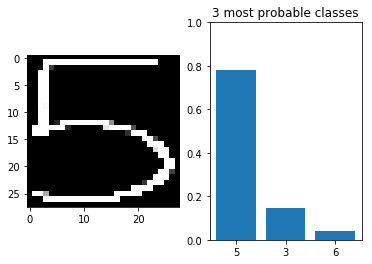

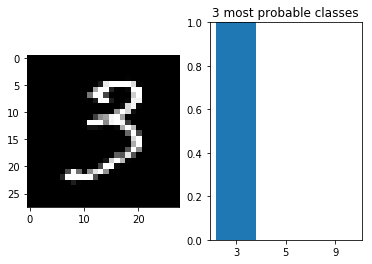

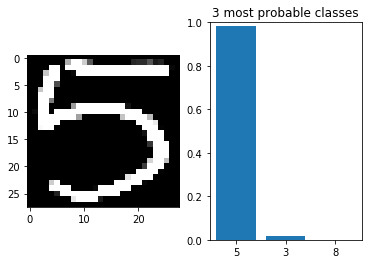

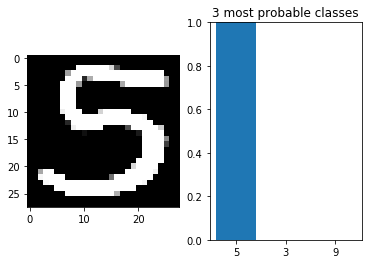

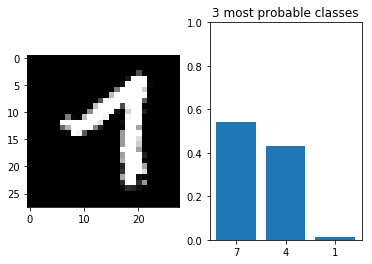

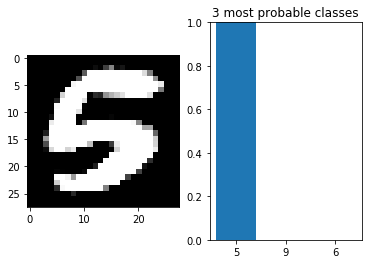

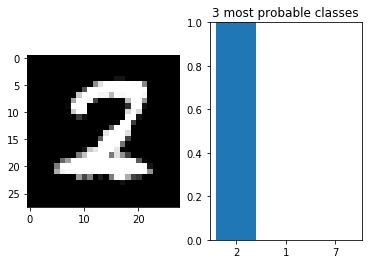

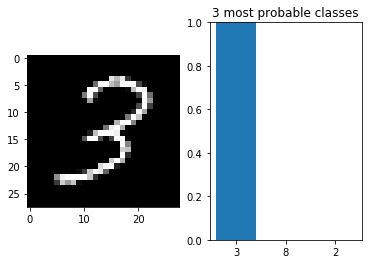

In [14]:
#train_model()
model = load_trained_model('mnist_cnn_weights.h5')
k = 15 #boarder

def extrac_number(model, region, image, angle):
    (min_row, min_col, max_row, max_col) = region.bbox
    number = image[min_row-k:max_row+k, min_col-k:max_col+k]
    number = 1-number
    small_number = skimage.transform.resize(number,(28,28), mode='constant')
    small_number = skimage.transform.rotate(small_number,angle=angle)
    small_number_reshaped = small_number.reshape([-1,28, 28,1])
    max_prediction = np.max(model.predict(small_number_reshaped))
    return small_number, max_prediction

def get_most_prob_orientation(model, number_region, image):
    image_array = []
    prediction_array = []
    tmp_max = 0 
    tmp_image_array = []
    
    for angle in [0, 90, 180, 270]:
        for region in number_region:
            sn, mp = extrac_number(model, region, image, angle)
            image_array.append(sn)
            prediction_array.append(mp)
        if tmp_max < sum(prediction_array):
            tmp_max = sum(prediction_array)
            tmp_image_array = image_array
        image_array = []
        prediction_array = []
            
    return tmp_image_array

image_array = get_most_prob_orientation(model, large_regions, transformed_image_binary)

#    #small_number_reshaped[small_number_reshaped>0.5]=1
#    #small_number_reshaped[small_number_reshaped<=0.5]=0
prediction_array = []
for idx, image in enumerate(image_array):
    small_number_reshaped = image.reshape([-1,28, 28,1])
    prediction = model.predict(small_number_reshaped)
    plot_pred_prob(image, prediction)
    prediction_array.append(np.argmax(prediction))

print("Detected numbers: {} in file {}".format(prediction_array, filename))


The two following steps are a very dirty way to repeate calculations for all other images without rewriting everything.

In [15]:
index = index+1
if index >= len(img):
    assert False

In [16]:
#%%javascript
#var i
#for(i=2; i<17; i++) {
#    Jupyter.notebook.execute_cells([i]);
#}